# Case study of uniaxial compression tests

This is an example of how to use Paramaterial to process a dataset of uniaxial compression test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as p
%matplotlib inline


In [2]:
import paramaterial
import importlib

importlib.reload(paramaterial)
pam = paramaterial
DataSet, DataItem = pam.plug.DataSet, pam.plug.DataItem

## Data preparation


### Backup data and raw data
1. Create two directories: "data", "info".
2. Save all csv files into a directory called "data/00 backup data".
3. Generate a corresponding info table "info/00 backup info.xlsx" using make_info_table function. The function writes the table to a spreadsheet and returns it as a dataframe.
5. Fill in the info and save backup info and data.
6. Copy to raw info and data.

In [3]:
backup_info = pam.preparing.make_info_table('data/00 backup data', columns=['temperature', 'rate', 'material'])
backup_info.to_excel('info/00 backup info unfilled.xlsx')
backup_info.head()

,test id,old filename,temperature,rate,material
0,NaN,testID_0080.csv,NaN,NaN,NaN
1,NaN,testID_0081.csv,NaN,NaN,NaN
2,NaN,testID_0082.csv,NaN,NaN,NaN
3,NaN,testID_0083.csv,NaN,NaN,NaN
4,NaN,testID_0084.csv,NaN,NaN,NaN


Add the metadata into the excel spreadsheet.
Apply a naming convention in the "test id" column.

In [4]:
backup_info = pd.read_excel('info/00 backup info.xlsx')
backup_info.head()

,test id,old filename,test type,material,temperature,rate,L_0,D_0
0,baron_test_001,testID_0080.csv,UC,AC,300,100,15,10
1,baron_test_002,testID_0081.csv,UC,AC,300,100,15,10
2,baron_test_003,testID_0082.csv,UC,AC,330,100,15,10
3,baron_test_004,testID_0083.csv,UC,AC,330,100,15,10
4,baron_test_005,testID_0084.csv,UC,AC,360,100,15,10


Copy backup data and info into raw data and info, then leave backup alone in all further steps.

In [5]:
pam.preparing.copy_data_and_info(old_data_dir='data/00 backup data', new_data_dir='data/01 prepared data',
                                 old_info_path='info/00 backup info.xlsx', new_info_path='info/01 prepared info.xlsx')

Copied 167 files from data/00 backup data to data/01 prepared data.
Copied info table from info/00 backup info.xlsx to info/01 prepared info.xlsx.


### Prepared data

Rename files according to test id.

In [6]:
# pam.preparing.rename_by_test_id('data/01 prepared data', 'info/01 prepared info.xlsx')

Check that column headers of data files are all the same. If not the same, fix.

In [7]:
pam.preparing.check_column_headers('data/01 prepared data')

Checking column headers...
First file headers:
	['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Strain', 'Stress(MPa)', 'Stroke(mm)', 'TC1(C)', 'wedge(mm)']
Headers in all files are the same as in the first file.


In [8]:
raw_dataset = DataSet('data/01 prepared data', 'info/01 prepared info.xlsx')

### Dataitem EDA
Look at one dataitem. Notice the use of the square brackets to get a subset, then to get a slice, then to get a single item.

In [9]:
dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][0] # todo: speed up get item
# dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][1]
# dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][2]

dataitem

DataItem Object -- test id: baron_test_065, info length: 8, data length: 9977
info index: ['test id', 'old filename', 'test type', 'material', 'temperature', 'rate', 'L_0', 'D_0']
data columns: ['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Strain', 'Stress(MPa)', 'Stroke(mm)', 'TC1(C)', 'wedge(mm)']

In [10]:
dataitem.data = dataitem.data.drop(columns=['PowAngle(deg)', 'Power(W)', 'Pram', 'Stroke(mm)', 'wedge(mm)', 'PTemp'])
# sns.pairplot(pd.concat([dataitem.data.iloc[:-199:200], dataitem.data.iloc[-10:]]), hue='TC1(C)', palette='plasma')

### Dataset EDA

In [11]:
raw_info = raw_dataset.info_table
raw_info.head()

,test id,old filename,test type,material,temperature,rate,L_0,D_0
0,baron_test_001,testID_0080.csv,UC,AC,300,100,15,10
1,baron_test_002,testID_0081.csv,UC,AC,300,100,15,10
2,baron_test_003,testID_0082.csv,UC,AC,330,100,15,10
3,baron_test_004,testID_0083.csv,UC,AC,330,100,15,10
4,baron_test_005,testID_0084.csv,UC,AC,360,100,15,10


In [12]:
raw_info.nunique()

test id         167
old filename    167
test type         1
material          3
temperature       6
rate              4
L_0               1
D_0               1
dtype: int64

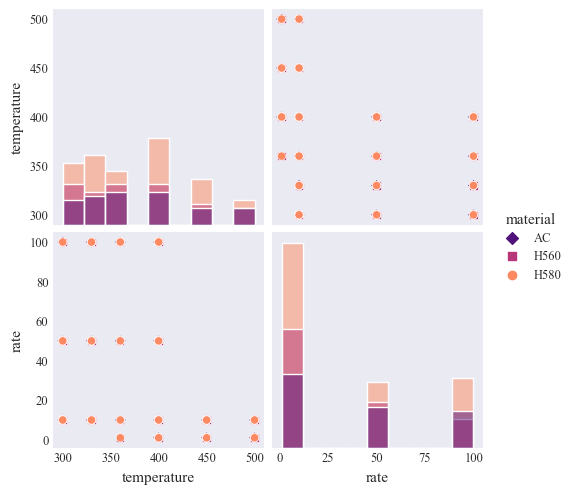

In [13]:
sns.pairplot(raw_info, vars=['temperature', 'rate'], hue='material', diag_kind='hist', markers=['D', 's', 'o'],
             palette='magma')

In [14]:
data_matrix = raw_info[['material', 'temperature', 'rate']].value_counts().sort_index()
data_matrix

material  temperature  rate
AC        300          10      2
                       50      2
                       100     2
          330          10      2
                       50      3
                       100     2
          360          10      2
                       50      3
                       100     3
          400          1       2
                       10      2
                       50      2
                       100     2
          450          1       2
                       10      2
          500          1       2
                       10      2
H560      300          10      6
                       50      2
                       100     2
          330          10      4
                       50      2
                       100     2
          360          1       2
                       10      4
                       50      2
                       100     2
          400          1       2
                       10      2
               

Make the experimental matrix.

In [15]:
data_matrix = data_matrix.to_frame().reset_index()
data_matrix.columns = ['material', 'temperature', 'rate', 'count']
data_matrix.pivot_table(index=['material', 'rate'], columns='temperature', values='count').fillna(0).astype(int)

temperature    300  330  360  400  450  500
material rate                              
AC       1       0    0    0    2    2    2
         10      2    2    2    2    2    2
         50      2    3    3    2    0    0
         100     2    2    3    2    0    0
H560     1       0    0    2    2    3    2
         10      6    4    4    2    2    2
         50      2    2    2    5    0    0
         100     2    2    2    1    0    0
H580     1       0    0    1    5    4    2
         10      9    7    4    7    7    4
         50      4    5    3    4    0    0
         100     2    5    5    5    0    0

Plot the dataset.

Iterating over DataItems in DataSet: 167it [00:02, 56.07it/s]


<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>

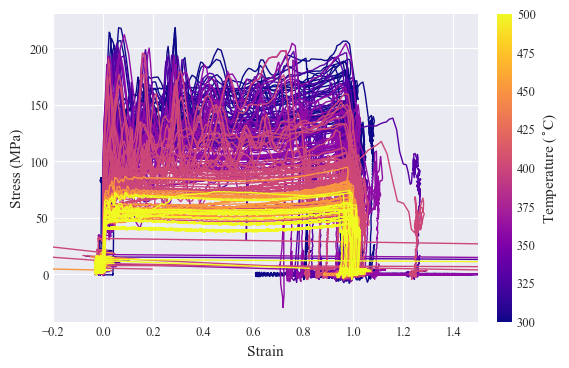

In [16]:
# configure dataset plot
ds_plot = lambda dataset, **kwargs: pam.plotting.dataset_plot(
    dataset, x='Strain', y='Stress(MPa)', ylabel='Stress (MPa)',
    cbar_by='temperature', cbar_label='Temperature ($^{\circ}$C)',
    xlim=(-0.2, 1.5), grid=True, **kwargs
)
ds_plot(raw_dataset)

In [17]:
# configure dataset subplot
ds_subplot = lambda dataset: pam.plotting.dataset_subplots(
    dataset, x='Strain', y='Stress(MPa)', ylabel='Stress (MPa)',
    nrows=3, ncols=4, rows_by='material', cols_by='rate',
    row_keys=[['AC'], ['H560'], ['H580']], col_keys=[[1], [10], [50], [100]],
    row_titles=['AC', 'H560', 'H580'], col_titles=['1 s$^{-1}$', '10 s$^{-1}$', '50 s$^{-1}$', '100 s$^{-1}$'],
    cbar_by='temperature', cbar_label='Temperature ($^{\circ}$C)',
    xlim=(-0.2, 1.5), grid=True, wspace=0.05, hspace=0.05
)
# ds_subplot(raw_dataset)

## Processing
We now want to:
- Trim the data
- Apply friction corrections
- Make representative curves
- Screen the data

### Trimming the data
- Remove unnecessary columns
- Trim leading and trailing data using time-step change
- Trim remaining trailing data after max force

In [18]:
def drop_columns(di: DataItem) -> DataItem:
    di.data = di.data.drop(columns=['PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Stroke(mm)', 'wedge(mm)'])
    return di

raw_dataset = raw_dataset.apply_function(drop_columns)
raw_dataset

DataSet:
info_table:
rows=167
head=
          test id     old filename test type material  temperature  rate  L_0  D_0
0  baron_test_001  testID_0080.csv        UC       AC          300   100   15   10
1  baron_test_002  testID_0081.csv        UC       AC          300   100   15   10
2  baron_test_003  testID_0082.csv        UC       AC          330   100   15   10
3  baron_test_004  testID_0083.csv        UC       AC          330   100   15   10
4  baron_test_005  testID_0084.csv        UC       AC          360   100   15   10
First DataItem Object -- test id: baron_test_001, info length: 8, data length: 6898
info index: ['test id', 'old filename', 'test type', 'material', 'temperature', 'rate', 'L_0', 'D_0']
data columns: ['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'Strain', 'Stress(MPa)', 'TC1(C)']

#### Trim using sampling rate change
After calculating the time-steps, we remove data that was sampled with a larger time-step.

<AxesSubplot:>

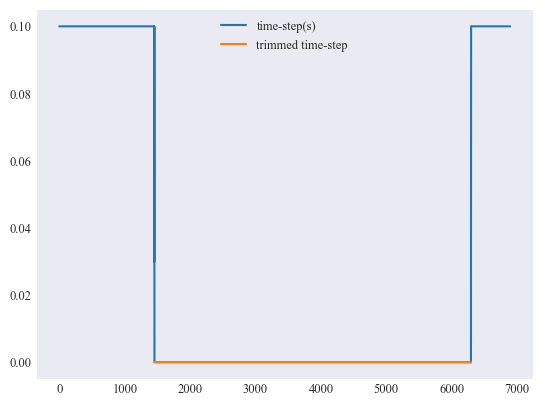

In [19]:
# calculate time-step
dataitem = raw_dataset[0]
time_step = np.diff(dataitem.data['Time(sec)'])
dataitem.data['time-step(s)'] = np.hstack([time_step[0], time_step])
ax = dataitem.data.plot(y='time-step(s)')
# trim by time-step
dataitem.data = dataitem.data[dataitem.data['time-step(s)'] < 0.02]
dataitem.data.plot(ax=ax, y='time-step(s)', label='trimmed time-step')

Trim dataset using time-step change. Notice how the origin data has been cleaned.

Iterating over DataItems in DataSet: 167it [00:03, 54.71it/s]


<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>

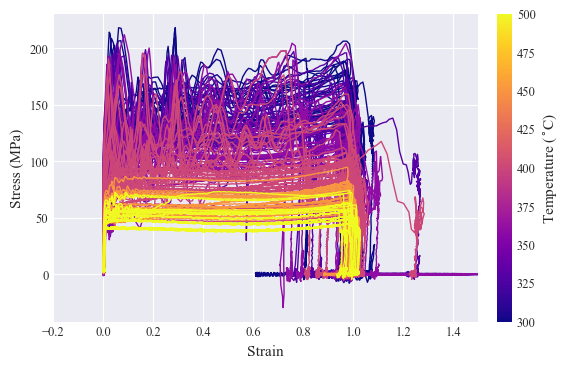

In [20]:
def trim_using_time_step_change(di: DataItem) -> DataItem:
    t_diff = np.diff(di.data['Time(sec)'])
    di.data['time diff'] = np.hstack([t_diff[0], t_diff])
    di.data = di.data[di.data['time diff'] < 0.02]
    return di


trimmed_dataset = raw_dataset.apply_function(trim_using_time_step_change)
ds_plot(trimmed_dataset)
# ds_subplot(trimmed_dataset)

#### Trim using max force
The end of a compression test can be identified my the maximum force.

<AxesSubplot:xlabel='Strain'>

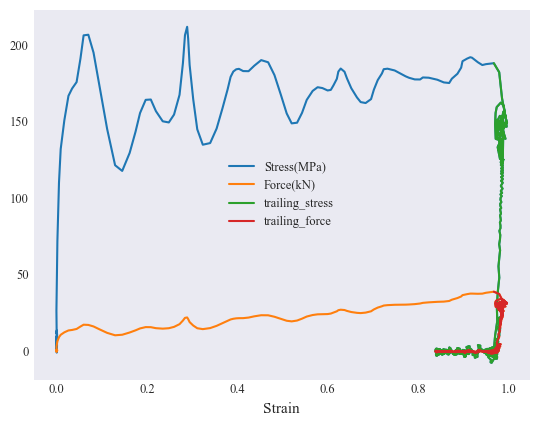

In [21]:
# investigate using max force index for trimming stress
dataitem = trimmed_dataset[0]

max_force_index = dataitem.data['Force(kN)'].idxmax()
trailing_data = dataitem.data.iloc[max_force_index:].copy()
trailing_data[['trailing_stress', 'trailing_force']] = trailing_data[['Stress(MPa)', 'Force(kN)']]
trailing_data['trailing_force'] = trailing_data['Force(kN)']

ax = dataitem.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])
trailing_data.plot(ax=ax, x='Strain', y=['trailing_stress', 'trailing_force'])

<AxesSubplot:xlabel='Strain'>

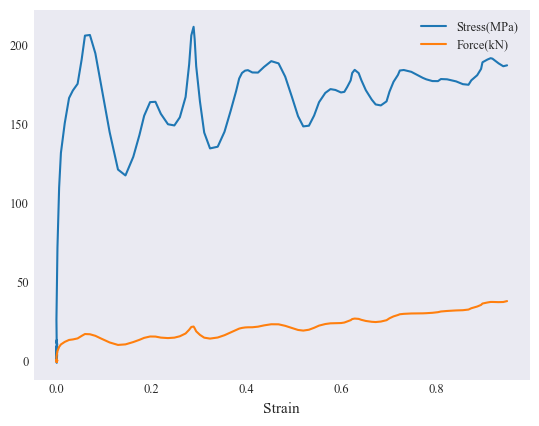

In [22]:
# demonstrate max force trimming for one dataitem
def remove_trailing_data(di: DataItem):
    di.data = di.data.iloc[:di.data['Force(kN)'].idxmax()]
    return di


trimmed_dataitem = remove_trailing_data(dataitem)
trimmed_dataitem.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])

Trim dataset using max force. Notice how the trailing data is trimmed.

Iterating over DataItems in DataSet: 167it [00:03, 54.38it/s]


<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>

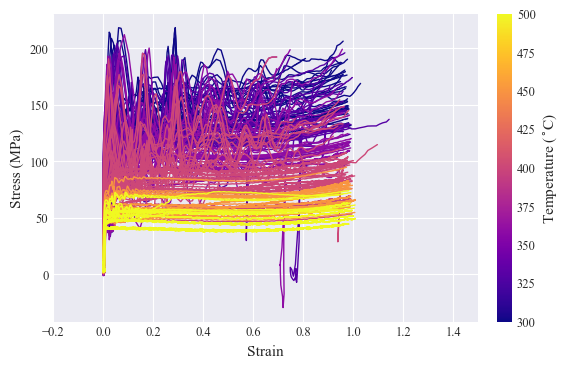

In [23]:
trimmed_dataset = trimmed_dataset.apply_function(remove_trailing_data)
ds_plot(trimmed_dataset)

### Applying the friction correction.
$$
\sigma = P \left[\frac{h}{\mu d} \right]^{-2}\left[\exp\left(\frac{\mu d}{h}\right) - \frac{\mu d}{h} - 1 \right]^{-1}
$$

In [24]:
trimmed_dataset[0]

DataItem Object -- test id: baron_test_001, info length: 8, data length: 815
info index: ['test id', 'old filename', 'test type', 'material', 'temperature', 'rate', 'L_0', 'D_0']
data columns: ['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'Strain', 'Stress(MPa)', 'TC1(C)', 'time diff']

<AxesSubplot:xlabel='Strain'>

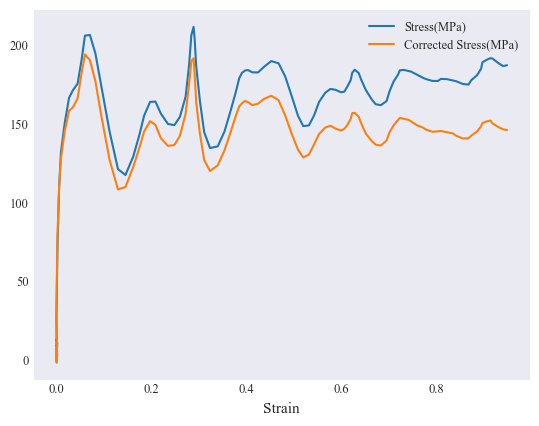

In [25]:
# demonstrate friction correction for one dataitem
dataitem = trimmed_dataset[0]

h_0 = dataitem.info['L_0']  # initial height in axial direction
d_0 = dataitem.info['D_0']  # initial diameter

h = h_0 - dataitem.data['Jaw(mm)']  # instantaneous height
d = d_0*np.sqrt(h_0/h)  # instantaneous diameter
P = dataitem.data['Force(kN)']*1000*4/(np.pi*d ** 2)  # pressure (MPa)
mu = 0.3  # friction coefficient

dataitem.data['Corrected Stress(MPa)'] = P/(1 + (mu*d)/(3*h))
dataitem.data.plot(x='Strain', y=['Stress(MPa)', 'Corrected Stress(MPa)'])

Iterating over DataItems in DataSet: 167it [00:03, 49.13it/s]


<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>

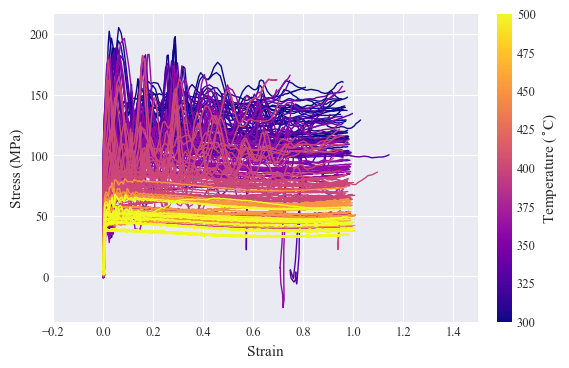

In [26]:
# apply friction correction function to dataset
def friction_correction(di: DataItem) -> DataItem:
    mu = 0.3  # friction coefficient
    h_0 = di.info['L_0']  # initial height in axial direction
    d_0 = di.info['D_0']  # initial diameter
    h = h_0 - di.data['Jaw(mm)']  # instantaneous height
    d = d_0*np.sqrt(h_0/h)  # instantaneous diameter
    P = di.data['Force(kN)']*1000*4/(np.pi*d ** 2)  # pressure (MPa)
    di.data['Pressure(MPa)'] = P
    di.data['Stress(MPa)'] = P/(1 + (mu*d)/(3*h))  # correct stress
    return di


corrected_dataset = trimmed_dataset.apply_function(friction_correction)
ds_plot(corrected_dataset)

Iterating over DataItems in DataSet: 100%|██████████| 6/6 [00:00<00:00, 171.89it/s]


<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>

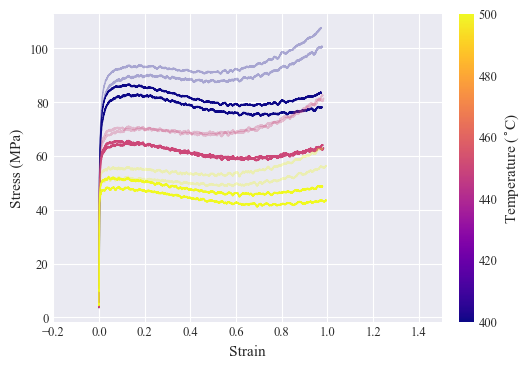

In [27]:
# compare corrected to un-corrected for a subset
ax = ds_plot(trimmed_dataset[{'material': ['AC'], 'rate': [1]}], alpha=0.3)
fig = ax.get_figure()
fig.delaxes(fig.axes[1])
ds_plot(corrected_dataset[{'material': ['AC'], 'rate': [1]}], ax=ax)

### Write processed data to new folder

In [28]:
corrected_dataset.write_output('data/02 processed data', 'info/02 processed info.xlsx')

Iterating over DataItems in DataSet: 167it [00:05, 31.10it/s]


### Make representative curves

In [29]:
pam.processing.make_representative_curves(corrected_dataset, 'data/03 repr data', 'info/03 repr info.xlsx',
                                          repr_col='Stress(MPa)', repr_by_cols=['temperature', 'material', 'rate'],
                                          interp_by='Strain')

Iterating over DataItems in DataSet: 100%|██████████| 2/2 [00:00<00:00, 334.14it/s]


Iterating over DataItems in DataSet:   0%|          | 0/3 [00:00<?, ?it/s]


KeyError: 'test id'

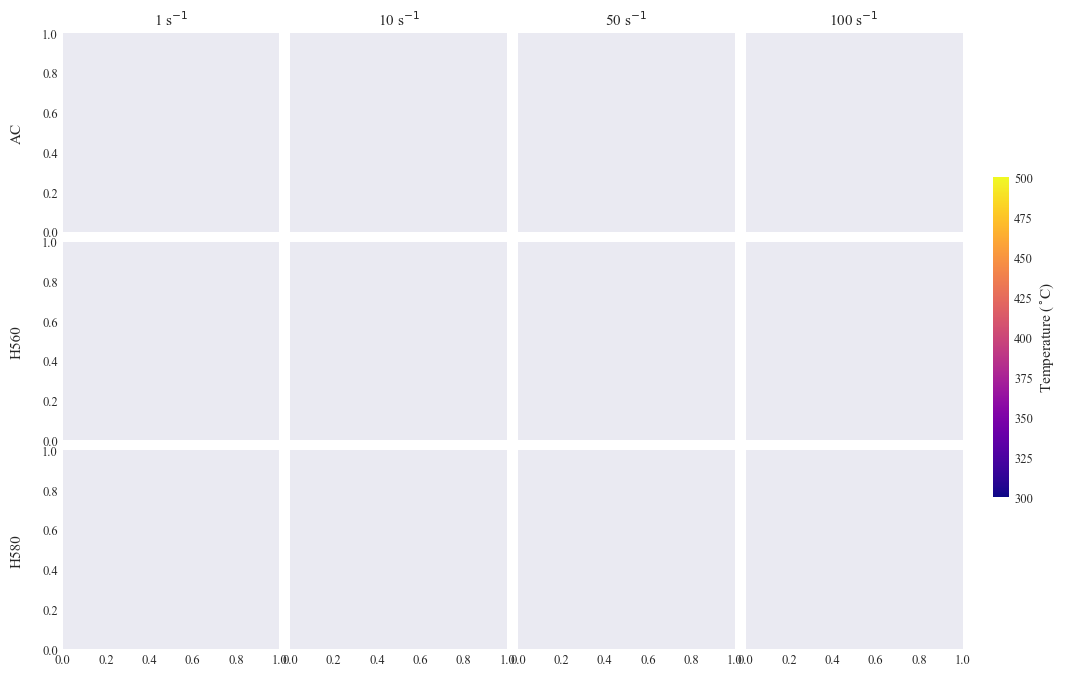

In [30]:
representative_dataset = DataSet('data/03 repr data', 'info/03 repr info.xlsx', test_id_key='repr id')

ds_subplot(representative_dataset)

## Screening
1. Setup a screening pdf
2. Add the repr curve
3. Add the data
4. Add the checkboxes
5. Make the pdf
6. Mark the pdf
7. Discard marked items

## Modelling
1. Identify points of interest algorithmically
2. Fit material model